# House Price Prediction Using Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Load and Inspect Data

In [2]:
df = pd.read_csv('data/AmesHousing.csv')
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

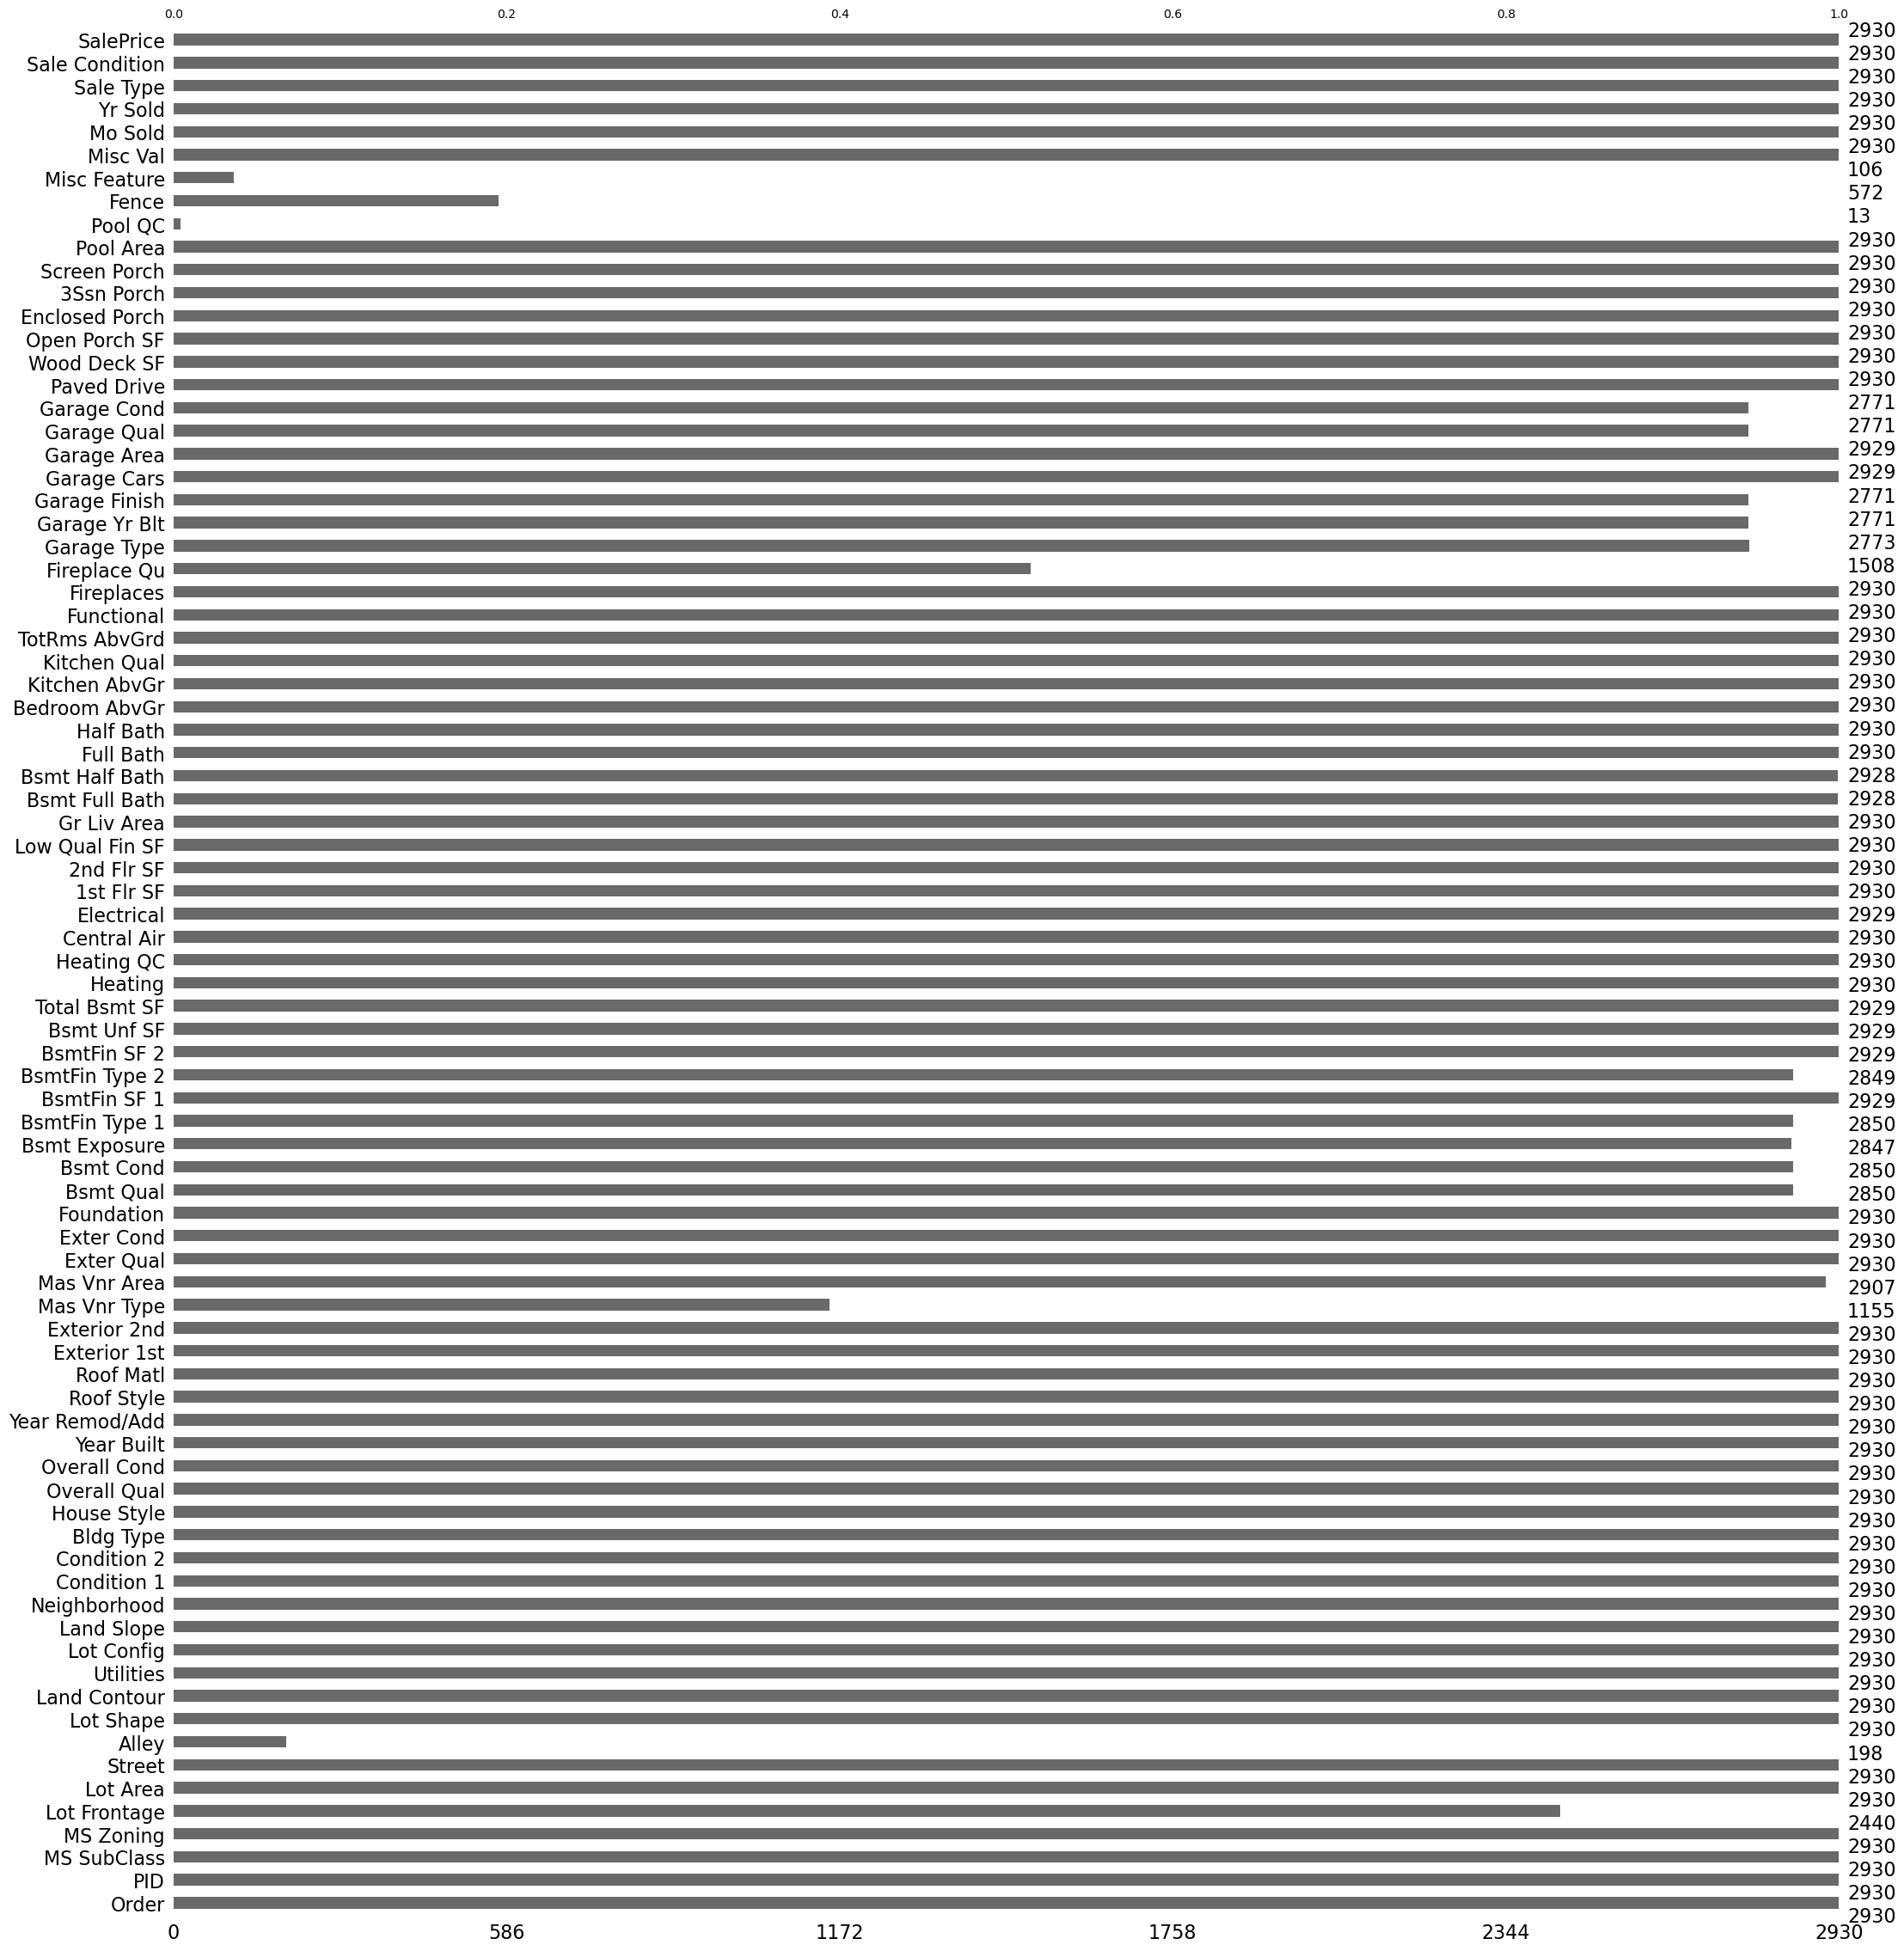

Pool QC         2917
Misc Feature    2824
Alley           2732
Fence           2358
Mas Vnr Type    1775
                ... 
PID                0
Central Air        0
1st Flr SF         0
2nd Flr SF         0
SalePrice          0
Length: 82, dtype: int64

In [3]:
df.info()
msno.bar(df)
plt.show()
df.describe()
df.isnull().sum().sort_values(ascending=False)

## Data Cleaning

In [4]:
#dropping columns
df.dropna(axis=1, thresh=len(df)*0.5, inplace=True)
#replace missing values with media-numerical columns
df.fillna(df.median(numeric_only=True), inplace=True)
#replace missing values with mode-categorical columns
df.fillna(df.mode().iloc[0], inplace=True)

In [18]:
#convert categorical variables
df = pd.get_dummies(df, drop_first=True)

## Exploratory Data Analysis

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


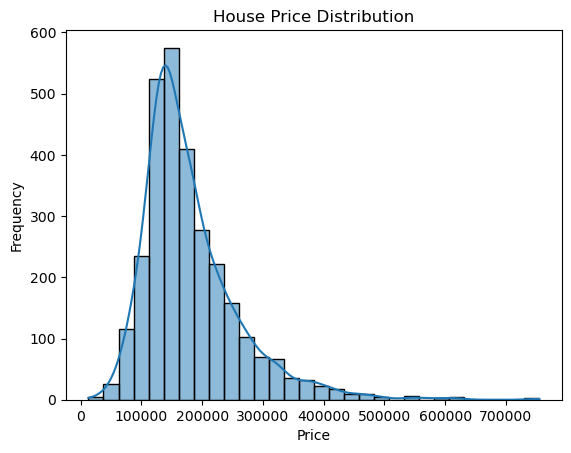

In [6]:
sns.histplot(df['SalePrice'], kde=True, bins=30)
plt.title('House Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

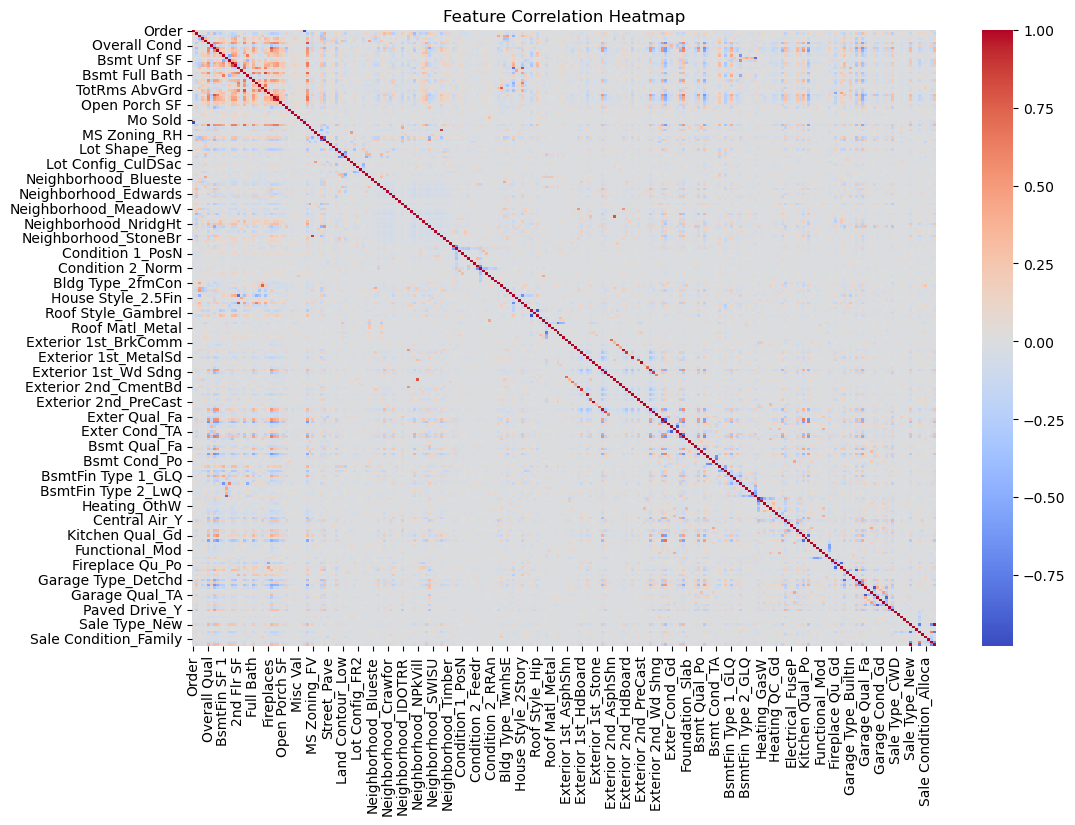

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

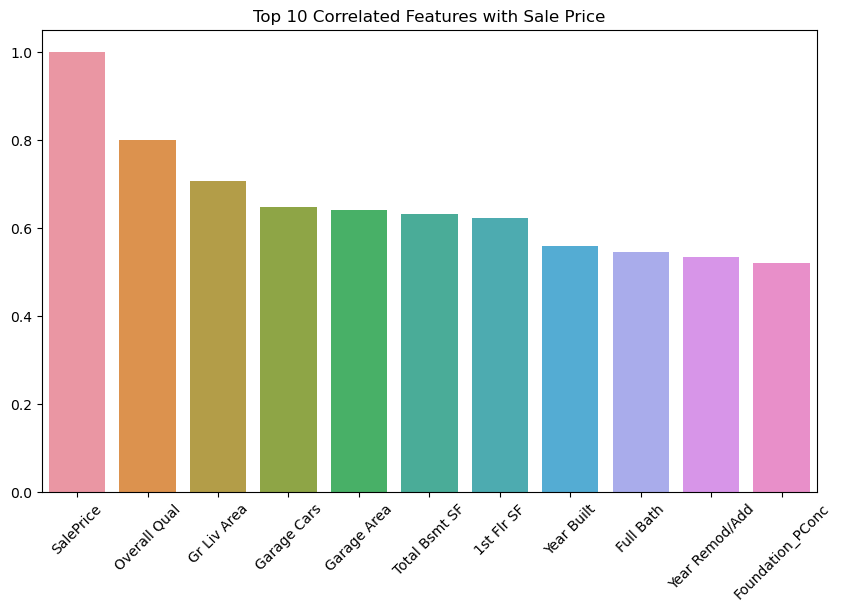

In [8]:
corr = df.corr()['SalePrice'].sort_values(ascending=False).head(11)
plt.figure(figsize=(10,6))
sns.barplot(x=corr.index, y=corr.values)
plt.xticks(rotation=45)
plt.title('Top 10 Correlated Features with Sale Price')
plt.show()

## Split Dataset

In [9]:
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Evaluation with K-Fold

In [10]:
def evaluate_model(model, X_train, y_train):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    return np.mean(scores), np.std(scores)

In [11]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

best_model = None
best_score = -np.inf
for name, model in models.items():
    mean_r2, std_r2 = evaluate_model(model, X_train, y_train)
    print(f"{name}: Mean R² = {mean_r2:.4f}, Std Dev = {std_r2:.4f}")
    if mean_r2 > best_score:
        best_score = mean_r2
        best_model = model
print(f"\nBest Model: {best_model} with R² = {best_score:.4f}")

Linear Regression: Mean R² = 0.7829, Std Dev = 0.1002
Random Forest: Mean R² = 0.8763, Std Dev = 0.0515
Gradient Boosting: Mean R² = 0.8885, Std Dev = 0.0637

Best Model: GradientBoostingRegressor(random_state=42) with R² = 0.8885


## Train Best Model and Evaluate on Test Set

In [12]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test Set Performance:\nMAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.4f}")

Test Set Performance:
MAE: 15238.02, MSE: 629375950.47, R²: 0.9215


## Save Best Model

In [13]:
joblib.dump(best_model, 'best_house_price_model.pkl')
print("Best model saved successfully as 'best_house_price_model.pkl'")

Best model saved successfully as 'best_house_price_model.pkl'


## Predict Price for New House

In [19]:
# Load trained model
model = joblib.load('best_house_price_model.pkl')

# Load dataset
df = pd.read_csv("data/AmesHousing.csv")

# Preprocess the data
df.dropna(axis=1, thresh=len(df)*0.5, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

# Split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use one actual sample from the training data
new_house = X_train.iloc[[100]]

# Predict the price
predicted_price = model.predict(new_house)
print(f"Predicted House Price: ${predicted_price[0]:,.2f}")


Predicted House Price: $129,043.71


## Save and Visualize Predictions

In [20]:
df_predictions = pd.DataFrame({
    'Actual Price': y_test.values,
    'Predicted Price': y_pred
})
df_predictions.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


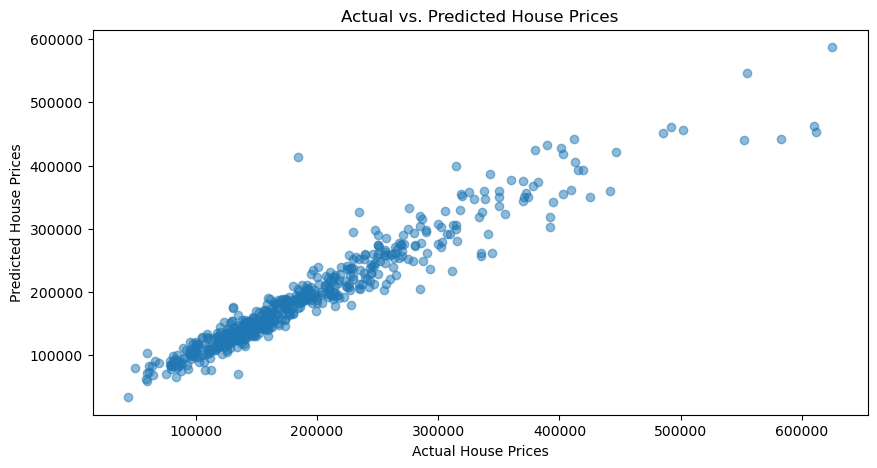

In [21]:
plt.figure(figsize=(10,5))
plt.scatter(df_predictions['Actual Price'], df_predictions['Predicted Price'], alpha=0.5)
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Actual vs. Predicted House Prices')
plt.show()

In [22]:
df_predictions['Error'] = df_predictions['Actual Price'] - df_predictions['Predicted Price']
print(f"Mean Absolute Error: {df_predictions['Error'].abs().mean():,.2f}")

Mean Absolute Error: 15,238.02
